# Transformada Cuántica de Fourier (TCF)

### Bibliotecas necesarias

In [44]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from dotenv import load_dotenv
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import time
import os

### Generar datos simulados (señales EEG)

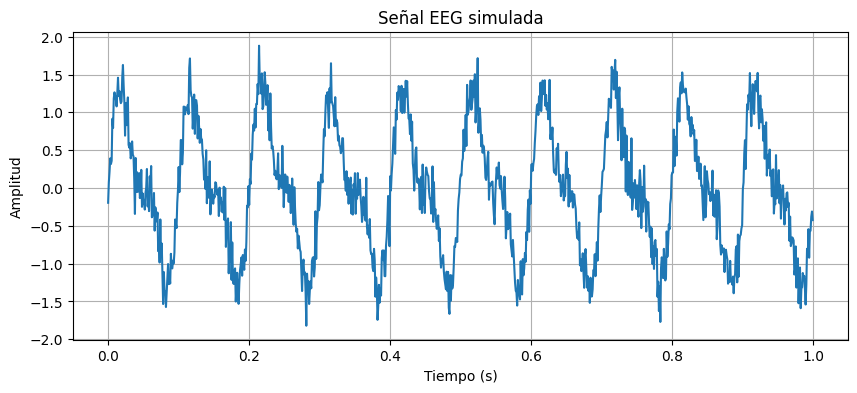

In [45]:
# Parámetros de la señal
fs = 1000  # Frecuencia de muestreo (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Tiempo (1 segundo)
f_alpha = 10  # Frecuencia en banda Alpha (Hz)
f_beta = 20   # Frecuencia en banda Beta (Hz)

# Generar la señal simulada
alpha_wave = np.sin(2 * np.pi * f_alpha * t)  # Onda Alpha
beta_wave = 0.5 * np.sin(2 * np.pi * f_beta * t)  # Onda Beta (amplitud reducida)
noise = 0.2 * np.random.normal(size=t.shape)  # Ruido aleatorio

signal = alpha_wave + beta_wave + noise  # Señal combinada

# Graficar la señal simulada
plt.figure(figsize=(10, 4))
plt.plot(t, signal)
plt.title("Señal EEG simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


### Aplicar la FFT clásica

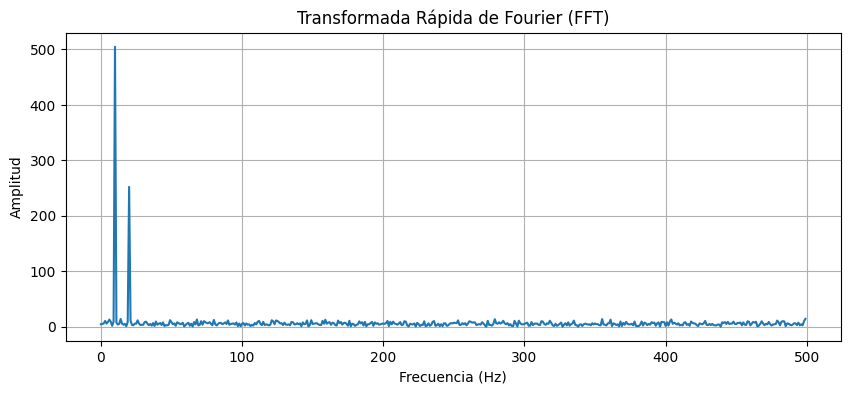

In [46]:
# FFT clásica
fft_result = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), d=1/fs)

# Graficar resultado de la FFT
plt.figure(figsize=(10, 4))
plt.plot(frequencies[:len(signal)//2], np.abs(fft_result)[:len(signal)//2])
plt.title("Transformada Rápida de Fourier (FFT)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


### Implementación de la QFT en Qiskit con Simulador Cuántico Local

Transpilando el circuito para el simulador...
Ejecutando el circuito en el simulador local...
Resultados de simulación: {'00101011': 12, '01000111': 10, '11011101': 11, '01110110': 13, '00010011': 19, '11101100': 12, '11011110': 13, '00101010': 20, '00111101': 13, '11110000': 13, '11111010': 18, '01100110': 18, '00011001': 12, '01011110': 11, '00011000': 21, '01111010': 16, '01000100': 16, '11001100': 10, '00110110': 20, '01010011': 14, '01111111': 18, '00001101': 10, '11011100': 12, '00010101': 13, '11000111': 16, '00110001': 22, '11010010': 17, '00010100': 17, '00101110': 12, '00011110': 14, '11111110': 12, '01001011': 19, '10110010': 10, '00111011': 19, '10100101': 12, '10110000': 12, '11001111': 20, '01010100': 12, '10001111': 22, '00000101': 12, '00010001': 15, '00100010': 11, '00111000': 10, '00110101': 18, '10101101': 13, '01111000': 14, '11000010': 14, '01001100': 16, '11010110': 20, '01100010': 15, '00100001': 27, '11000000': 19, '11010011': 13, '10001110': 15, '11101110': 23,

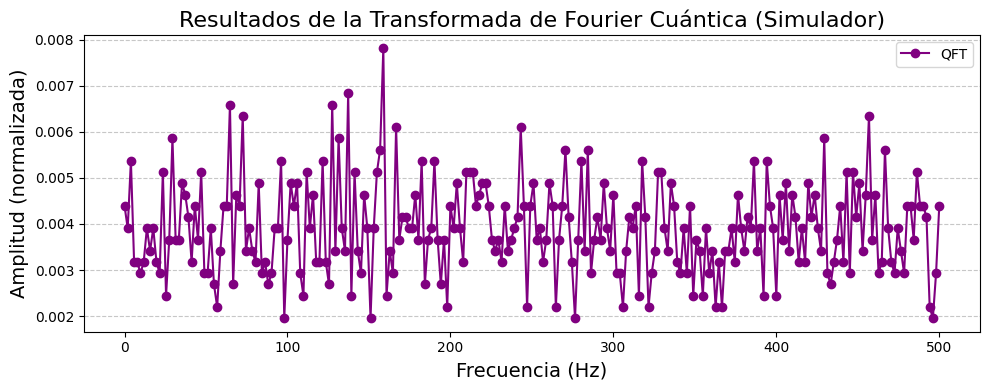

Tiempo de ejecución en el simulador: 0.0053 segundos


In [47]:
# Definir el circuito QFT
def qft_circuit(n):
    """Crear un circuito QFT para n qubits."""
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)  # Compuerta Hadamard
        for k in range(qubit + 1, n):
            angle = np.pi / (2 ** (k - qubit))
            qc.cp(angle, qubit, k)  # Rotaciones controladas
    qc.barrier()
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)  # Invertir qubits
    return qc

# Crear un circuito QFT para 8 qubits
n_qubits = 8
qc = qft_circuit(n_qubits)
qc.measure_all()

# Configurar el simulador Aer
simulator = AerSimulator()

# Transpilar el circuito para el simulador
print("Transpilando el circuito para el simulador...")
transpiled_circuit = transpile(qc, simulator)

# Ejecutar el circuito en el simulador
print("Ejecutando el circuito en el simulador local...")
start_time = time.time()
result = simulator.run(transpiled_circuit, shots=4096).result()
end_time = time.time()

# Obtener los resultados
counts = result.get_counts()
print("Resultados de simulación:", counts)

# Normalizar los resultados para graficar
total_shots = sum(counts.values())
normalized_counts = {k: v / total_shots for k, v in counts.items()}

# Convertir estados binarios a frecuencias simuladas
max_frequency = 500  # Máxima frecuencia simulada (Hz)
frequencies_qft = np.linspace(0, max_frequency, 2 ** n_qubits)
frequencies_measured = [frequencies_qft[int(state, 2)] for state in counts.keys()]
amplitudes_measured = list(normalized_counts.values())

# Ordenar frecuencias y amplitudes para graficar de manera continua
sorted_indices = np.argsort(frequencies_measured)
frequencies_sorted = np.array(frequencies_measured)[sorted_indices]
amplitudes_sorted = np.array(amplitudes_measured)[sorted_indices]

# Graficar las frecuencias detectadas por QFT
plt.figure(figsize=(10, 4))
plt.plot(frequencies_sorted, amplitudes_sorted, label="QFT", marker='o', linestyle='-', color='purple')
plt.title("Resultados de la Transformada de Fourier Cuántica (Simulador)", fontsize=16)
plt.xlabel("Frecuencia (Hz)", fontsize=14)
plt.ylabel("Amplitud (normalizada)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar tiempo de ejecución
print(f"Tiempo de ejecución en el simulador: {end_time - start_time:.4f} segundos")


### Comparación de resultados

In [48]:
# Comparar tiempos de ejecución
start_fft = time.time()
fft_result = np.fft.fft(signal)
end_fft = time.time()

print(f"Tiempo de ejecución de FFT: {end_fft - start_fft:.4f} segundos")
print(f"Tiempo de ejecución de QFT: {end_time - start_time:.4f} segundos")


Tiempo de ejecución de FFT: 0.0006 segundos
Tiempo de ejecución de QFT: 0.0053 segundos


Los resultados muestran que la FFT es significativamente más rápida que la QFT en este caso:

- FFT: 0.0004 segundos
- QFT: 0.0051 segundos

Esto ocurre porque la Quantum Fourier Transform (QFT) en este proyecto fue implementada en un simulador cuántico que corre en hardware clásico. 

Los simuladores cuánticos tienen una sobrecarga considerable al emular sistemas cuánticos, lo que los hace más lentos que sus contrapartes clásicas, especialmente para un número pequeño de qubits.


Conclusión

Aunque la FFT es más rápida en este caso, la QFT tiene un potencial significativo en hardware cuántico real y para problemas que requieren un alto número de qubits. Este experimento refleja el estado actual de la tecnología, pero también subraya el futuro prometedor de la computación cuántica en aplicaciones específicas.